## **Balancing Dataset**

In [ ]:
import os
import shutil
import random
from glob import glob

# Ganti dengan path ke folder Data
base_data_path = r'J:\My Drive\01. TUGAS AKHIR\FOLDER TA\SOFTWARE\STA\Training_model\Data'

# Ambil semua subfolder (diasumsikan 4 sumber dataset)
dataset_paths = [os.path.join(base_data_path, name) for name in os.listdir(base_data_path) if os.path.isdir(os.path.join(base_data_path, name))]

# Path output
output_base = r'J:\My Drive\01. TUGAS AKHIR\FOLDER TA\SOFTWARE\STA\Training_model\Balanced_Dataset'
output_normal = os.path.join(output_base, 'Normal')
output_ppok = os.path.join(output_base, 'PPOK')
os.makedirs(output_normal, exist_ok=True)
os.makedirs(output_ppok, exist_ok=True)

# Kumpulkan file Normal dan PPOK dari semua dataset
normal_files = []
ppok_files_per_dataset = [[] for _ in dataset_paths]

for idx, path in enumerate(dataset_paths):
    normal_path = os.path.join(path, 'Normal')
    ppok_path = os.path.join(path, 'PPOK')

    normal_files += glob(os.path.join(normal_path, '*.npy'))
    ppok_files = glob(os.path.join(ppok_path, '*.npy'))
    ppok_files_per_dataset[idx] = ppok_files

# Hitung jumlah Normal dan target PPOK
num_normal = len(normal_files)
target_ppok_total = int(1.2 * num_normal)
print(f'[INFO] Total file Normal  : {num_normal}')
print(f'[INFO] Target file PPOK   : {target_ppok_total}')

# Hitung rasio PPOK dari tiap dataset
total_ppok_available = sum(len(p) for p in ppok_files_per_dataset)
ppok_ratios = [len(p)/total_ppok_available for p in ppok_files_per_dataset]
ppok_quota = [int(r * target_ppok_total) for r in ppok_ratios]

# Koreksi agar total quota tepat 1.2x normal
diff = target_ppok_total - sum(ppok_quota)
ppok_quota[0] += diff  # Tambahkan sisa ke dataset pertama

# Tambahan ini untuk cetak jumlah file PPOK yang dipilih per sumber dataset
print('\n[DETAIL JUMLAH PPOK YANG DIAMBIL DARI MASING-MASING SUMBER]:')
for idx, (quota, path) in enumerate(zip(ppok_quota, dataset_paths)):
    folder_name = os.path.basename(path)
    print(f'  - {folder_name:<20}: {quota} file PPOK')

# Pilih PPOK secara acak sesuai quota
selected_ppok_files = []
for idx, quota in enumerate(ppok_quota):
    selected = random.sample(ppok_files_per_dataset[idx], quota)
    selected_ppok_files += selected

print(f'[INFO] PPOK dipilih total : {len(selected_ppok_files)}')

# Salin file Normal
for f in normal_files:
    shutil.copy(f, output_normal)

# Salin file PPOK
for f in selected_ppok_files:
    shutil.copy(f, output_ppok)

print('[DONE] Dataset balanced telah disalin ke folder Balanced_Dataset')

[INFO] Total file Normal  : 367
[INFO] Target file PPOK   : 440

[DETAIL JUMLAH PPOK YANG DIAMBIL DARI MASING-MASING SUMBER]:
  - Asthma Detection Dataset Version 2: 145 file PPOK
  - HLS-CMDS            : 0 file PPOK
  - KAUH                : 11 file PPOK
  - ICBHI 17            : 284 file PPOK
  - Data_primer         : 0 file PPOK
[INFO] PPOK dipilih total : 440
[DONE] Dataset balanced telah disalin ke folder Balanced_Dataset


In [4]:
import os
import csv

balanced_path = r'J:\My Drive\01. TUGAS AKHIR\FOLDER TA\SOFTWARE\STA\Training_model\Balanced_Dataset'
source_data_path = r'J:\My Drive\01. TUGAS AKHIR\FOLDER TA\SOFTWARE\STA\Training_model\Data'
csv_output = os.path.join(balanced_path, 'labels.csv')

# 1. Index semua file asal di Data/ per label
print("📦 Membaca semua file asal dari folder Data...")
source_map = {}  # key = filename, value = (label, source_dataset)

for dataset_folder in os.listdir(source_data_path):
    dataset_path = os.path.join(source_data_path, dataset_folder)
    if os.path.isdir(dataset_path):
        for label in ['Normal', 'PPOK']:
            label_path = os.path.join(dataset_path, label)
            if os.path.isdir(label_path):
                for fname in os.listdir(label_path):
                    if fname.endswith('.npy'):
                        source_map[fname] = (label, dataset_folder.lower())  # lowercase biar seragam

print(f"📁 Total file asal ditemukan: {len(source_map)}")

# 2. Cek setiap file di Balanced_Dataset dan cari asalnya
print("🔍 Membuat labels.csv dari folder Balanced_Dataset...")
with open(csv_output, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['filename', 'label', 'source'])

    for label in ['Normal', 'PPOK']:
        label_folder = os.path.join(balanced_path, label)
        for fname in os.listdir(label_folder):
            if fname in source_map:
                orig_label, source = source_map[fname]
                writer.writerow([fname, label, source])
            else:
                print(f"⚠️ WARNING: File {fname} tidak ditemukan di folder Data/ (asal tidak diketahui)")
                
print(f"\n✅ [DONE] File labels.csv berhasil dibuat di:\n{csv_output}")


📦 Membaca semua file asal dari folder Data...
📁 Total file asal ditemukan: 1593
🔍 Membuat labels.csv dari folder Balanced_Dataset...

✅ [DONE] File labels.csv berhasil dibuat di:
J:\My Drive\01. TUGAS AKHIR\FOLDER TA\SOFTWARE\STA\Training_model\Balanced_Dataset\labels.csv


In [5]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

# === 1. Path
balanced_path = r'J:\My Drive\01. TUGAS AKHIR\FOLDER TA\SOFTWARE\STA\Training_model\Balanced_Dataset'
csv_path = os.path.join(balanced_path, 'labels.csv')
output_path = r'J:\My Drive\01. TUGAS AKHIR\FOLDER TA\SOFTWARE\STA\Training_model\Folds'

# === 2. Load CSV
df = pd.read_csv(csv_path)

# === 3. Tambahkan kolom stratifikasi kombinasi label+source
df['strat'] = df['label'] + '_' + df['source']

# === 4. Tambahkan kolom path penuh ke file npy
df['full_path'] = df.apply(lambda row: os.path.join(balanced_path, row['label'], row['filename']), axis=1)

# === 5. Siapkan Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 6. Loop tiap fold
for fold, (trainval_idx, test_idx) in enumerate(skf.split(df, df['strat'])):
    print(f'\n📂 Membuat Fold {fold+1}...')

    df_trainval = df.iloc[trainval_idx].reset_index(drop=True)
    df_test = df.iloc[test_idx].reset_index(drop=True)

    for subset_name, subset_df in zip(['Train_Val', 'Test'], [df_trainval, df_test]):
        for _, row in tqdm(subset_df.iterrows(), total=len(subset_df), desc=f'{subset_name}'):
            label = row['label']
            src = row['full_path']
            dest_dir = os.path.join(output_path, f'Fold_{fold+1}', subset_name, label)
            os.makedirs(dest_dir, exist_ok=True)
            np.save(os.path.join(dest_dir, row['filename']), np.load(src))

print('\n✅ [DONE] Semua Fold berhasil dibuat di folder Folds/')


📂 Membuat Fold 1...


Test: 100%|██████████| 162/162 [00:03<00:00, 50.18it/s]



📂 Membuat Fold 2...


Test: 100%|██████████| 162/162 [00:04<00:00, 33.16it/s]



📂 Membuat Fold 3...


Test: 100%|██████████| 161/161 [00:04<00:00, 37.44it/s]



📂 Membuat Fold 4...


Test: 100%|██████████| 161/161 [00:04<00:00, 32.67it/s]



📂 Membuat Fold 5...


Test: 100%|██████████| 161/161 [00:04<00:00, 37.81it/s]


✅ [DONE] Semua Fold berhasil dibuat di folder Folds/


## **TRAINING**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential, regularizers # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional # type: ignore
from tensorflow.keras.losses import BinaryCrossentropy # type: ignore
from tensorflow.keras.metrics import AUC # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint # type: ignore
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
import gc
from tqdm import tqdm

In [106]:
def load_data_with_path(base_path):
    X, y, paths = [], [], []
    for label in os.listdir(base_path):
        folder = os.path.join(base_path, label)
        if os.path.isdir(folder):
            for file in os.listdir(folder):
                if file.endswith('.npy'):
                    full_path = os.path.join(folder, file)
                    X.append(np.load(full_path))
                    y.append(label)
                    paths.append(full_path)
    return X, y, paths

In [73]:
import os
import numpy as np
from sklearn.model_selection import train_test_split # type: ignore
from tqdm import tqdm # type: ignore

# ======================= PATH ==========================
base_path = "J:/My Drive/01. TUGAS AKHIR/FOLDER TA/SOFTWARE/STA/Training_model/Balanced_Dataset"
output_base_path = "J:/My Drive/01. TUGAS AKHIR/FOLDER TA/SOFTWARE/STA/Training_model/Processed_Data2"

# Buat folder output jika belum ada
os.makedirs(output_base_path, exist_ok=True)

# ======================= PROSES ========================
# 1. Load Data & Path
X, y, file_paths = load_data_with_path(base_path)

# 2. Split Train-Test
X_train, X_test, y_train, y_test, f_train, f_test = train_test_split(
    X, y, file_paths, test_size=0.15, stratify=y, random_state=42
)

# 3. Simpan TEST ke folder: Processed_Data/Test/{label}
print("📁 Menyimpan data TEST:")
for x, label, src_path in tqdm(zip(X_test, y_test, f_test), total=len(X_test)):
    dest_dir = os.path.join(output_base_path, 'Test', label)
    os.makedirs(dest_dir, exist_ok=True)
    filename = os.path.basename(src_path)
    np.save(os.path.join(dest_dir, filename), x)

# 4. Simpan TRAIN/VAL ke folder: Processed_Data/Train_Val/{label}
print("📁 Menyimpan data TRAIN/VAL:")
for x, label, src_path in tqdm(zip(X_train, y_train, f_train), total=len(X_train)):
    dest_dir = os.path.join(output_base_path, 'Train_Val', label)
    os.makedirs(dest_dir, exist_ok=True)
    filename = os.path.basename(src_path)
    np.save(os.path.join(dest_dir, filename), x)

📁 Menyimpan data TEST:


100%|██████████| 122/122 [00:01<00:00, 68.04it/s]


📁 Menyimpan data TRAIN/VAL:


100%|██████████| 685/685 [00:09<00:00, 70.84it/s]


In [124]:
def load_data_from_folder(folder_path, allowed_labels=['Normal', 'PPOK']):
    X_list = []
    y_list = []

    for class_name in os.listdir(folder_path):
        if class_name not in allowed_labels:
            continue  # skip folder lain yang bukan Normal/PPOK

        class_dir = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        for file in os.listdir(class_dir):
            if file.endswith(".npy"):
                file_path = os.path.join(class_dir, file)
                data = np.load(file_path)
                X_list.append(data)
                y_list.append(class_name)

    return X_list, y_list

In [125]:
X_list, y_list = load_data_from_folder("J:/My Drive/01. TUGAS AKHIR/FOLDER TA/SOFTWARE/STA/Training_model/Processed_Data2/Train_Val")

In [126]:
# Label
from sklearn.preprocessing import LabelEncoder # type: ignore

le = LabelEncoder()
y_encoded = le.fit_transform(y_list)  

print(le.classes_)     # ['Normal' 'Penyakit']
print(le.transform(['Normal', 'PPOK']))  # [0 1]

['Normal' 'PPOK']
[0 1]


In [127]:
import pickle 

# Path tujuan simpan encoder
save_dir = "J:/My Drive/01. TUGAS AKHIR/FOLDER TA/SOFTWARE/STA/Training_model/Processed_Data2/Label"
os.makedirs(save_dir, exist_ok=True)  

# Simpan
with open(os.path.join(save_dir, "label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)

In [128]:
# Load nanti
with open(os.path.join(save_dir, "label_encoder.pkl"), "rb") as f:
    le_loaded = pickle.load(f)

In [129]:
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore

def prepare_data_for_lstm(X_list, y_list, max_len=None):
    if max_len is None:
        max_len = max([x.shape[0] for x in X_list])  # panjang frame terpanjang

    X_padded = pad_sequences(X_list, maxlen=max_len, dtype='float32', padding='post', truncating='post')
    y_array = np.array(y_list)
    return X_padded, y_array

In [130]:
X, y_encoded = prepare_data_for_lstm(X_list, y_encoded)

print("X shape:", X.shape)
print("y shape:", y_encoded.shape)

X shape: (685, 1368, 13)
y shape: (685,)



=== Fold 1 ===
Class weights: {0: 1.096, 1: 0.9194630872483222}
Epoch 1/150


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 638ms/step - accuracy: 0.5130 - auprc: 0.5650 - auroc: 0.5273 - loss: 0.9160 - val_accuracy: 0.5328 - val_auprc: 0.6156 - val_auroc: 0.5423 - val_loss: 0.6972 - learning_rate: 5.0000e-05
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 593ms/step - accuracy: 0.4934 - auprc: 0.5203 - auroc: 0.4840 - loss: 0.9509 - val_accuracy: 0.5328 - val_auprc: 0.6522 - val_auroc: 0.5635 - val_loss: 0.6940 - learning_rate: 5.0000e-05
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 647ms/step - accuracy: 0.4821 - auprc: 0.5783 - auroc: 0.4867 - loss: 0.9325 - val_accuracy: 0.5693 - val_auprc: 0.6896 - val_auroc: 0.5904 - val_loss: 0.6886 - learning_rate: 5.0000e-05
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 600ms/step - accuracy: 0.5772 - auprc: 0.6586 - auroc: 0.6086 - loss: 0.7903 - val_accuracy: 0.5766 - val_auprc: 0.7208 - val_auroc: 0.6169 - val_loss: 0.6808 - learning_rate: 5.0000e-05
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 621ms/step - accuracy: 0.5198 - auprc: 0.6079 - a

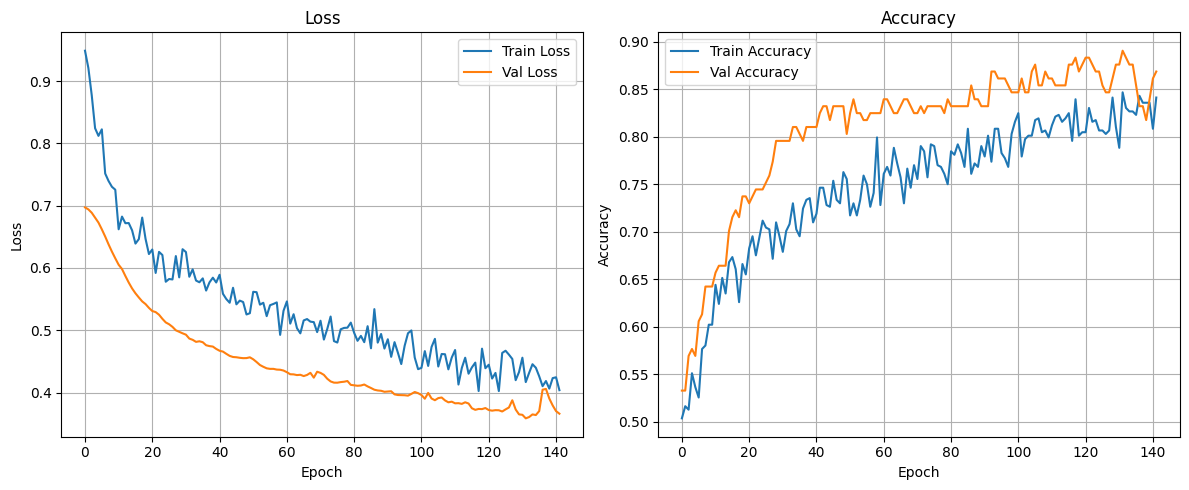

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 413ms/step
              precision    recall  f1-score   support

      Normal       0.87      0.89      0.88        62
        PPOK       0.91      0.89      0.90        75

    accuracy                           0.89       137
   macro avg       0.89      0.89      0.89       137
weighted avg       0.89      0.89      0.89       137



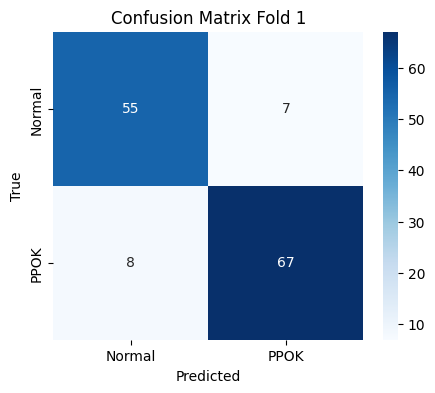

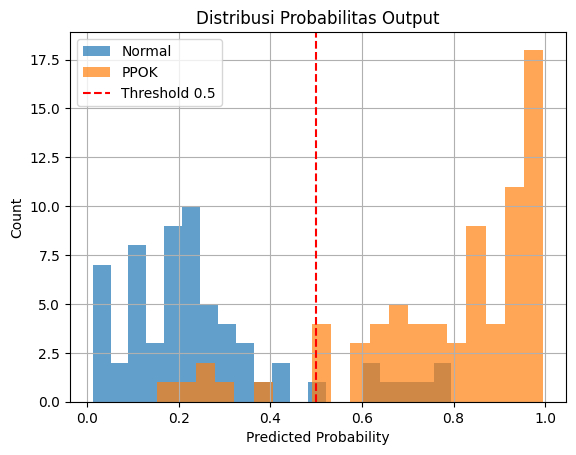


=== Fold 2 ===
Class weights: {0: 1.096, 1: 0.9194630872483222}


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5166 - auprc: 0.5775 - auroc: 0.5428 - loss: 0.8806 - val_accuracy: 0.6277 - val_auprc: 0.7263 - val_auroc: 0.6870 - val_loss: 0.6511 - learning_rate: 5.0000e-05
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5773 - auprc: 0.5951 - auroc: 0.5644 - loss: 0.8701 - val_accuracy: 0.5985 - val_auprc: 0.7317 - val_auroc: 0.6967 - val_loss: 0.6405 - learning_rate: 5.0000e-05
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 993ms/step - accuracy: 0.5311 - auprc: 0.6329 - auroc: 0.5699 - loss: 0.8244 - val_accuracy: 0.6204 - val_auprc: 0.7446 - val_auroc: 0.7186 - val_loss: 0.6264 - learning_rate: 5.0000e-05
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5400 - auprc: 0.5971 - auroc: 0.5765 - loss: 0.8264 - val_accuracy: 0.6496 - val_auprc: 0.7727 - val_auroc: 0.7472 - val_loss: 0.6119 - learning_rate: 5.0000e-05
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.5697 - auprc: 0.6294 - a

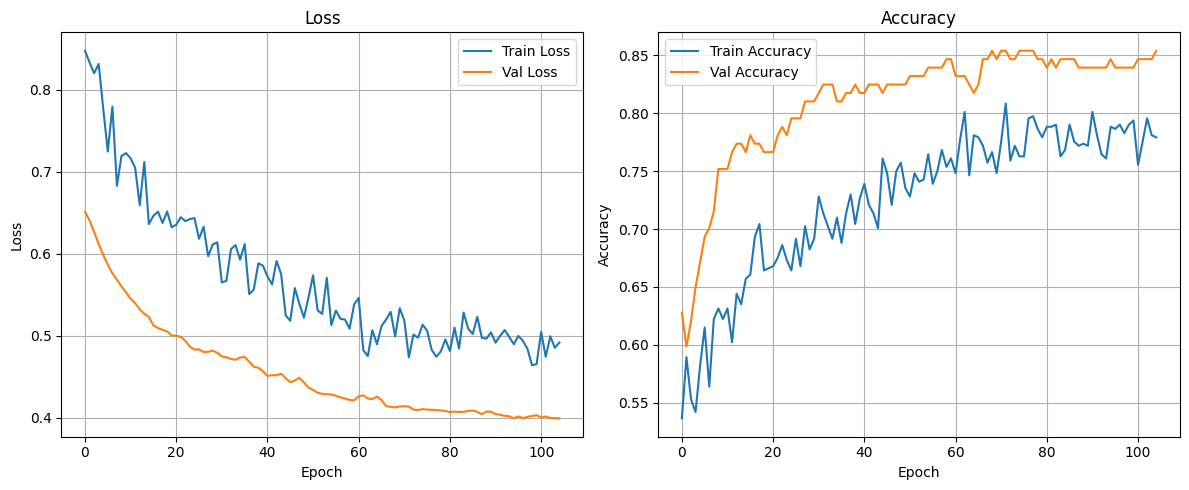

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step
              precision    recall  f1-score   support

      Normal       0.79      0.90      0.84        62
        PPOK       0.91      0.80      0.85        75

    accuracy                           0.85       137
   macro avg       0.85      0.85      0.85       137
weighted avg       0.85      0.85      0.85       137



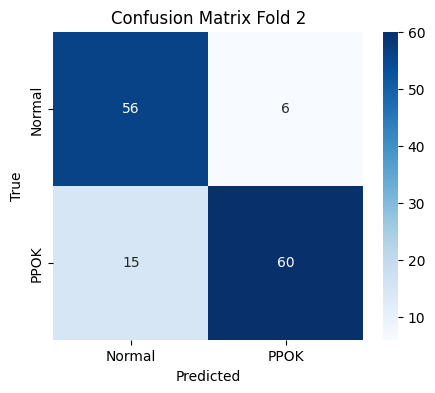

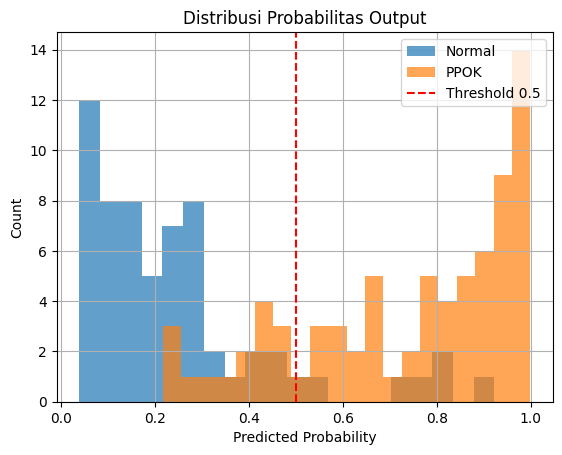


=== Fold 3 ===
Class weights: {0: 1.096, 1: 0.9194630872483222}
Epoch 1/150


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 648ms/step - accuracy: 0.5074 - auprc: 0.5811 - auroc: 0.5212 - loss: 0.9078 - val_accuracy: 0.5912 - val_auprc: 0.6825 - val_auroc: 0.6755 - val_loss: 0.6777 - learning_rate: 5.0000e-05
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 671ms/step - accuracy: 0.5405 - auprc: 0.5878 - auroc: 0.5338 - loss: 0.8766 - val_accuracy: 0.6131 - val_auprc: 0.6904 - val_auroc: 0.6868 - val_loss: 0.6659 - learning_rate: 5.0000e-05
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 664ms/step - accuracy: 0.5635 - auprc: 0.5940 - auroc: 0.5762 - loss: 0.8392 - val_accuracy: 0.6715 - val_auprc: 0.6933 - val_auroc: 0.6885 - val_loss: 0.6582 - learning_rate: 5.0000e-05
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 642ms/step - accuracy: 0.5356 - auprc: 0.5925 - auroc: 0.5484 - loss: 0.8462 - val_accuracy: 0.6496 - val_auprc: 0.7059 - val_auroc: 0.6919 - val_loss: 0.6522 - learning_rate: 5.0000e-05
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 617ms/step - accuracy: 0.5520 - auprc: 0.6134 - a

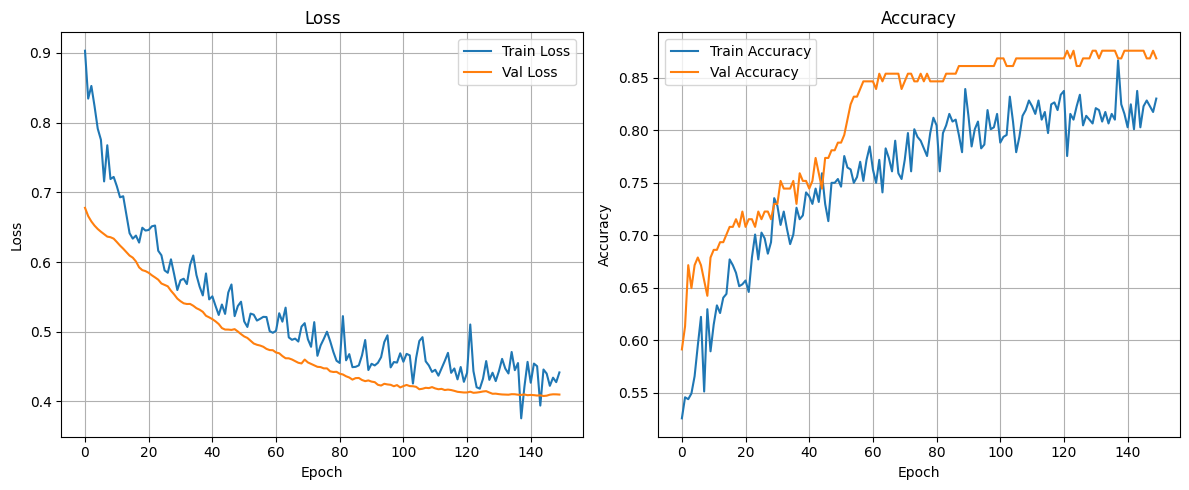

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step
              precision    recall  f1-score   support

      Normal       0.86      0.87      0.86        62
        PPOK       0.89      0.88      0.89        75

    accuracy                           0.88       137
   macro avg       0.87      0.88      0.87       137
weighted avg       0.88      0.88      0.88       137



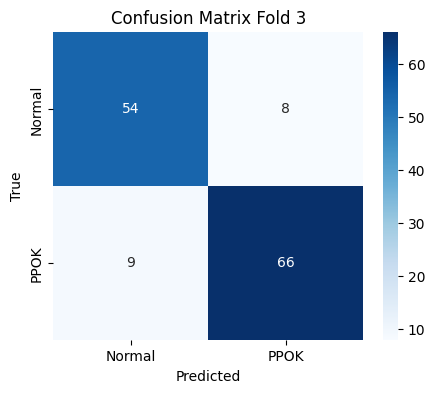

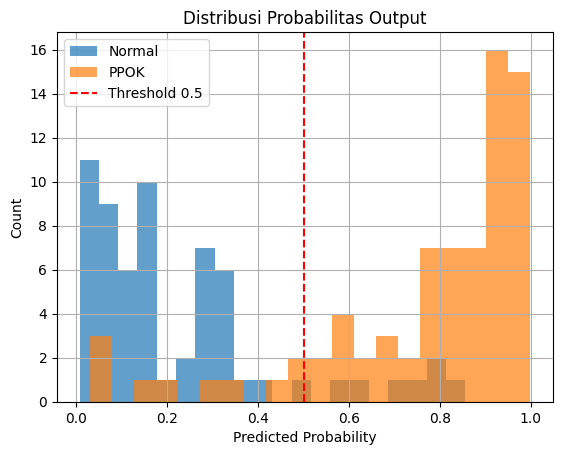


=== Fold 4 ===
Class weights: {0: 1.1004016064257027, 1: 0.9163879598662207}


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 712ms/step - accuracy: 0.4887 - auprc: 0.5251 - auroc: 0.4945 - loss: 0.9393 - val_accuracy: 0.4453 - val_auprc: 0.4841 - val_auroc: 0.4231 - val_loss: 0.7536 - learning_rate: 5.0000e-05
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 661ms/step - accuracy: 0.4970 - auprc: 0.5445 - auroc: 0.5090 - loss: 0.9132 - val_accuracy: 0.4526 - val_auprc: 0.5141 - val_auroc: 0.4517 - val_loss: 0.7441 - learning_rate: 5.0000e-05
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 640ms/step - accuracy: 0.5238 - auprc: 0.5411 - auroc: 0.4937 - loss: 0.9109 - val_accuracy: 0.4891 - val_auprc: 0.5452 - val_auroc: 0.4899 - val_loss: 0.7347 - learning_rate: 5.0000e-05
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 583ms/step - accuracy: 0.5007 - auprc: 0.5476 - auroc: 0.5207 - loss: 0.8930 - val_accuracy: 0.5401 - val_auprc: 0.5675 - val_auroc: 0.5215 - val_loss: 0.7284 - learning_rate: 5.0000e-05
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 627ms/step - accuracy: 0.5365 - auprc

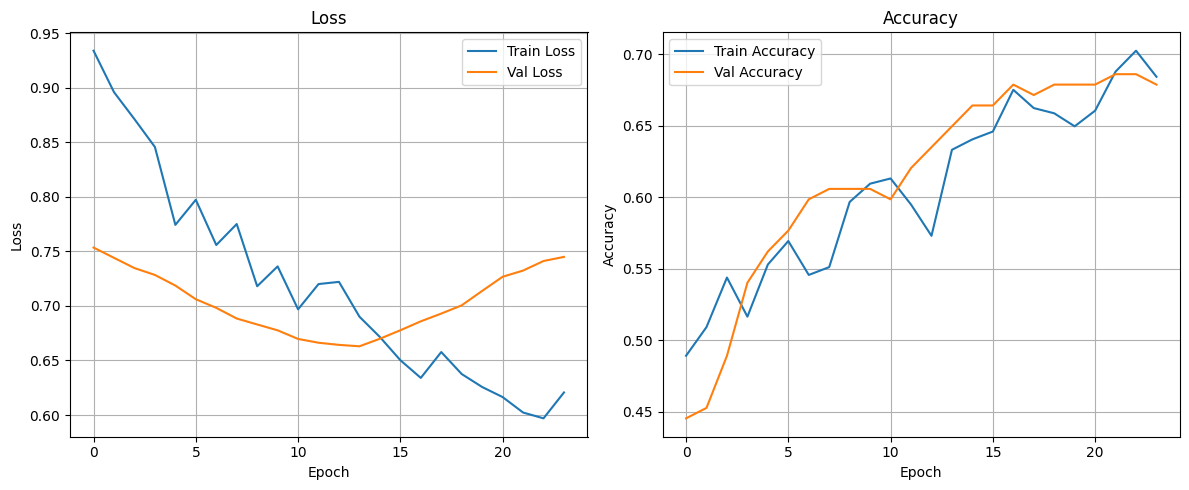

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step
              precision    recall  f1-score   support

      Normal       0.59      0.81      0.68        63
        PPOK       0.76      0.51      0.61        74

    accuracy                           0.65       137
   macro avg       0.67      0.66      0.65       137
weighted avg       0.68      0.65      0.64       137



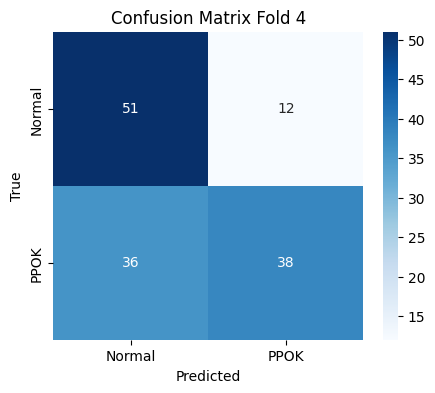

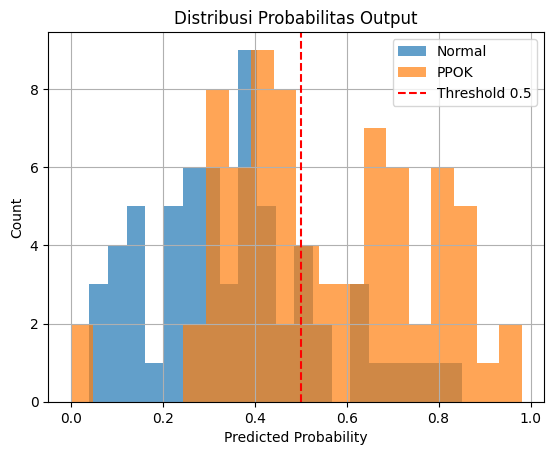


=== Fold 5 ===
Class weights: {0: 1.1004016064257027, 1: 0.9163879598662207}


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 836ms/step - accuracy: 0.4882 - auprc: 0.5753 - auroc: 0.5024 - loss: 0.9286 - val_accuracy: 0.5036 - val_auprc: 0.6244 - val_auroc: 0.5446 - val_loss: 0.6988 - learning_rate: 5.0000e-05
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 758ms/step - accuracy: 0.5135 - auprc: 0.5852 - auroc: 0.5291 - loss: 0.9034 - val_accuracy: 0.5182 - val_auprc: 0.6414 - val_auroc: 0.5691 - val_loss: 0.6897 - learning_rate: 5.0000e-05
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 795ms/step - accuracy: 0.5700 - auprc: 0.6375 - auroc: 0.5996 - loss: 0.8168 - val_accuracy: 0.5401 - val_auprc: 0.6537 - val_auroc: 0.5879 - val_loss: 0.6797 - learning_rate: 5.0000e-05
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 787ms/step - accuracy: 0.5731 - auprc: 0.6661 - auroc: 0.5930 - loss: 0.8219 - val_accuracy: 0.5620 - val_auprc: 0.6664 - val_auroc: 0.6089 - val_loss: 0.6713 - learning_rate: 5.0000e-05
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 782ms/step - accuracy: 0.5016 - auprc

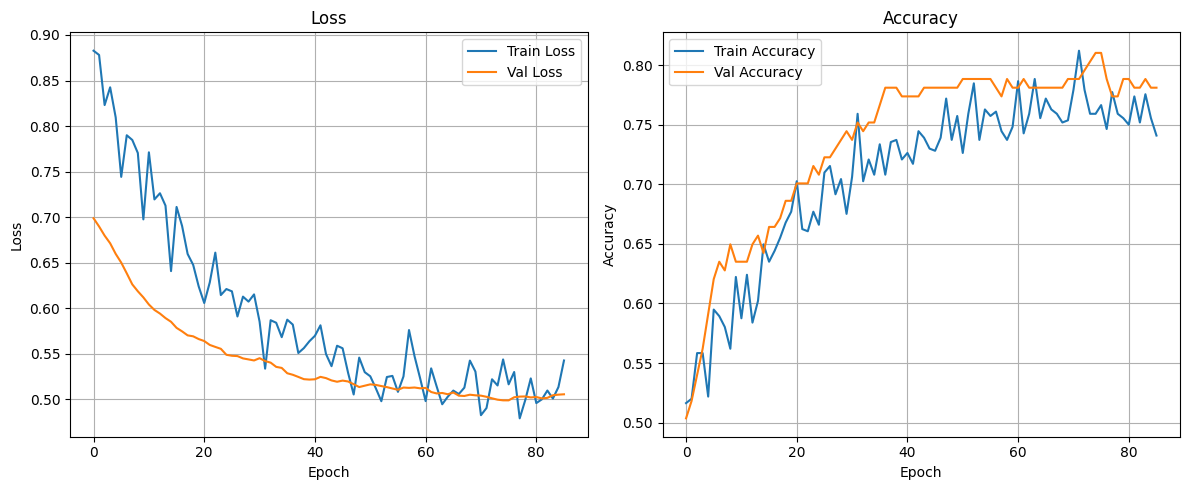

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step
              precision    recall  f1-score   support

      Normal       0.73      0.92      0.82        63
        PPOK       0.91      0.72      0.80        74

    accuracy                           0.81       137
   macro avg       0.82      0.82      0.81       137
weighted avg       0.83      0.81      0.81       137



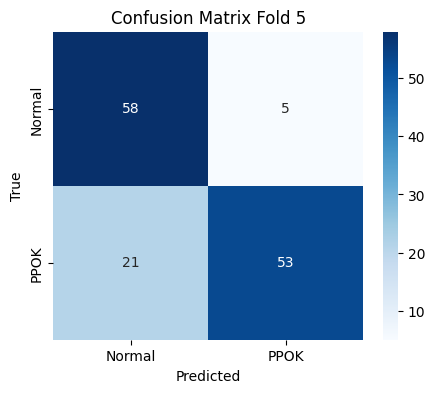

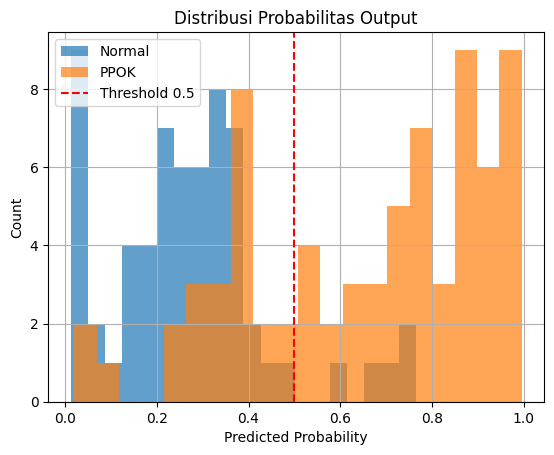

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1

# noise augmentation
def add_noise(X, noise_factor=0.01):
    noise = np.random.normal(0, noise_factor, X.shape)
    X_noisy = X + noise
    return X_noisy

for train_idx, val_idx in kfold.split(X, y_encoded):
    print(f"\n=== Fold {fold_no} ===")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

    # Augment hanya TRAINING SET
    X_train_noisy = add_noise(X_train, noise_factor=0.01)

    # Class weights
    class_weights = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(y_train),
                                         y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights:", class_weight_dict)

    # Model BiLSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, input_shape=(X.shape[1], X.shape[2]))))
    model.add(BatchNormalization())
    model.add(Dense(48, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4)))

    # Compile
    loss_fn = BinaryCrossentropy(label_smoothing=0.05)
    optimiser = tf.keras.optimizers.Adam(learning_rate=5e-5)
    model.compile(optimizer=optimiser, loss=loss_fn, metrics=['accuracy',
                                                              AUC(curve='ROC', name='auroc'),
                                                              AUC(curve='PR', name='auprc')])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    checkpoint_path = f"J:/My Drive/01. TUGAS AKHIR/FOLDER TA/SOFTWARE/STA/Training_model/Model Checkpoint3/Model_Fold{fold_no}.keras"
    model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

    # Train
    history = model.fit(
        X_train_noisy.astype('float32'), y_train.astype('int64'),
        epochs=150, batch_size=16,
        validation_data=(X_val.astype('float32'), y_val.astype('int64')),
        class_weight=class_weight_dict,
        callbacks=[model_checkpoint, reduce_lr, early_stopping])

    # Evaluate
    train_metrics = model.evaluate(X_train.astype('float32'), y_train.astype('int64'), batch_size=16)
    val_metrics = model.evaluate(X_val.astype('float32'), y_val.astype('int64'), batch_size=16)

    print(f'\nTrain Loss: {train_metrics[0]:.4f}, Accuracy: {train_metrics[1]:.4f}, AUROC: {train_metrics[2]:.4f}, AUPRC: {train_metrics[3]:.4f}')
    print(f'Val   Loss: {val_metrics[0]:.4f}, Accuracy: {val_metrics[1]:.4f}, AUROC: {val_metrics[2]:.4f}, AUPRC: {val_metrics[3]:.4f}')

    # Plot Loss & Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Predict
    y_prob = model.predict(X_val.astype('float32'), batch_size=16)
    y_pred = y_prob > 0.5

    print(classification_report(y_val, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'PPOK'], yticklabels=['Normal', 'PPOK'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix Fold {fold_no}')
    plt.show()

    # Histogram Probabilitas
    plt.hist(y_prob[y_val==0], bins=20, alpha=0.7, label='Normal')
    plt.hist(y_prob[y_val==1], bins=20, alpha=0.7, label='PPOK')
    plt.axvline(0.5, color='red', linestyle='--', label='Threshold 0.5')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.title('Distribusi Probabilitas Output')
    plt.legend()
    plt.grid()
    plt.show()

    fold_no += 1
    tf.keras.backend.clear_session()
    gc.collect()

In [65]:
label_encoder_path = "J:/My Drive/01. TUGAS AKHIR/FOLDER TA/SOFTWARE/STA/Training_model/Processed_Data/Label/label_encoder.pkl"

with open(label_encoder_path, "rb") as f:
    le = pickle.load(f)

# Pastikan y masih string label seperti ['Normal', 'PPOK', ...]
y_encoded = le.transform(y_list)

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_acc_per_fold = []
fold_no = 1

for train_idx, val_idx in kfold.split(X, y_encoded):
    print(f"\n=== Evaluating Fold {fold_no} ===")

    X_val = X[val_idx]
    y_val = y_encoded[val_idx]

    model_path = f"J:/My Drive/01. TUGAS AKHIR/FOLDER TA/SOFTWARE/STA/Training_model/Model Checkpoint3/Model_Fold{fold_no}.keras"
    model = tf.keras.models.load_model(model_path)

    # Ambil semua metrik
    eval_results = model.evaluate(X_val.astype('float32'), y_val.astype('int64'), batch_size=16, verbose=0)
    val_loss = eval_results[0]
    val_acc = eval_results[1]
    val_loss, val_acc, val_auroc, val_auprc = eval_results
    print(f"Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUROC: {val_auroc:.4f}, AUPRC: {val_auprc:.4f}")
    print(f"Validation Accuracy Fold {fold_no}: {val_acc:.4f}")
    val_acc_per_fold.append(val_acc)
    fold_no += 1

# Cari model terbaik
best_fold = np.argmax(val_acc_per_fold) + 1
print(f"\nModel terbaik ada di Fold {best_fold} dengan Validation Accuracy: {val_acc_per_fold[best_fold-1]:.4f}")


=== Evaluating Fold 1 ===
Loss: 0.3585, Acc: 0.8905, AUROC: 0.9441, AUPRC: 0.9575
Validation Accuracy Fold 1: 0.8905

=== Evaluating Fold 2 ===
Loss: 0.3992, Acc: 0.8467, AUROC: 0.9301, AUPRC: 0.9348
Validation Accuracy Fold 2: 0.8467

=== Evaluating Fold 3 ===
Loss: 0.4078, Acc: 0.8759, AUROC: 0.9184, AUPRC: 0.9440
Validation Accuracy Fold 3: 0.8759

=== Evaluating Fold 4 ===
Loss: 0.6630, Acc: 0.6496, AUROC: 0.7649, AUPRC: 0.7852
Validation Accuracy Fold 4: 0.6496

=== Evaluating Fold 5 ===
Loss: 0.4988, Acc: 0.8102, AUROC: 0.8790, AUPRC: 0.9097
Validation Accuracy Fold 5: 0.8102

Model terbaik ada di Fold 1 dengan Validation Accuracy: 0.8905


In [67]:
best_model_path = "J:/My Drive/01. TUGAS AKHIR/FOLDER TA/SOFTWARE/STA/Training_model/Model Checkpoint2/Model_Fold5.keras"
model = tf.keras.models.load_model(best_model_path)

X_test, y_test = load_data_from_folder("J:/My Drive/01. TUGAS AKHIR/FOLDER TA/SOFTWARE/STA/Training_model/Processed_Data/Test")

with open("J:/My Drive/01. TUGAS AKHIR/FOLDER TA/SOFTWARE/STA/Training_model/Processed_Data/Label/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# 2. Encode label test
#y_test_encoded = le.transform(y_test)
y_test_encoded = np.array(le.transform(y_test), dtype=np.int64)
model = tf.keras.models.load_model(best_model_path)

time_steps = model.input_shape[1]  # OK
n_features = model.input_shape[2]  # OK
time_steps

1368

In [ ]:
X_test_padded, y_test_encoded = prepare_data_for_lstm(X_test, y_test, max_len=time_steps)

# Transform label string → angka
y_test_encoded = le.transform(y_test)

# Pastikan hasilnya bertipe numerik (int64)
import numpy as np
y_test_encoded = np.array(y_test_encoded, dtype=np.int64)


=== Evaluasi Model Fold 1 ===
✅ Test Metrics Fold 1:
  Loss: 0.3448 | Acc: 0.8934 | AUROC: 0.9513 | AUPRC: 0.9686
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step

📄 Classification Report:
              precision    recall  f1-score   support

      Normal       0.83      0.96      0.89        55
        PPOK       0.97      0.84      0.90        67

    accuracy                           0.89       122
   macro avg       0.90      0.90      0.89       122
weighted avg       0.90      0.89      0.89       122



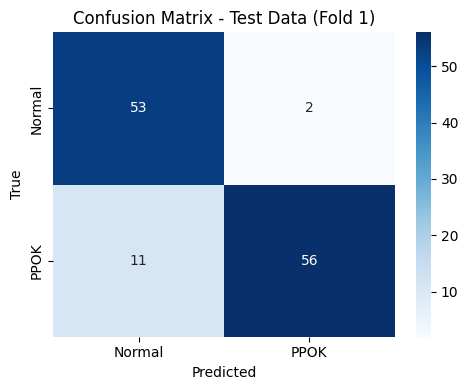

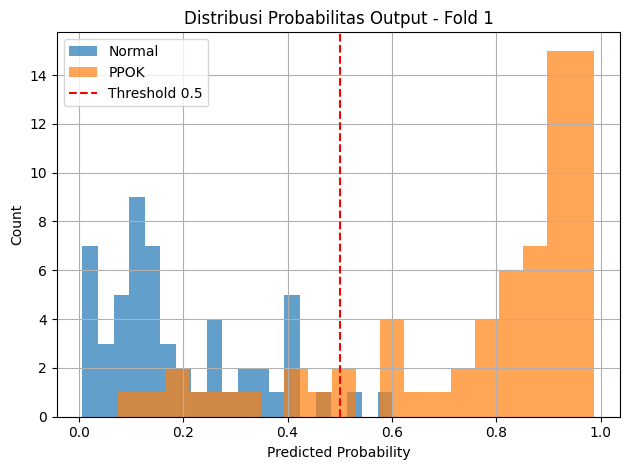


=== Evaluasi Model Fold 2 ===
✅ Test Metrics Fold 2:
  Loss: 0.3848 | Acc: 0.8361 | AUROC: 0.9457 | AUPRC: 0.9631
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step

📄 Classification Report:
              precision    recall  f1-score   support

      Normal       0.76      0.93      0.84        55
        PPOK       0.93      0.76      0.84        67

    accuracy                           0.84       122
   macro avg       0.84      0.84      0.84       122
weighted avg       0.85      0.84      0.84       122



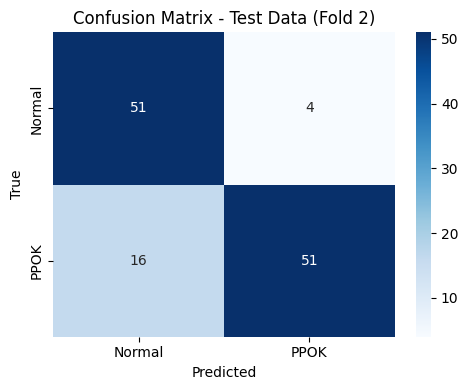

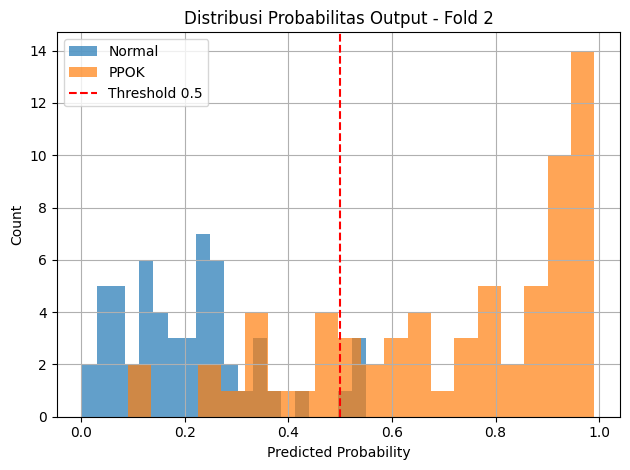


=== Evaluasi Model Fold 3 ===
✅ Test Metrics Fold 3:
  Loss: 0.3452 | Acc: 0.8852 | AUROC: 0.9624 | AUPRC: 0.9754
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step

📄 Classification Report:
              precision    recall  f1-score   support

      Normal       0.80      1.00      0.89        55
        PPOK       1.00      0.79      0.88        67

    accuracy                           0.89       122
   macro avg       0.90      0.90      0.89       122
weighted avg       0.91      0.89      0.89       122



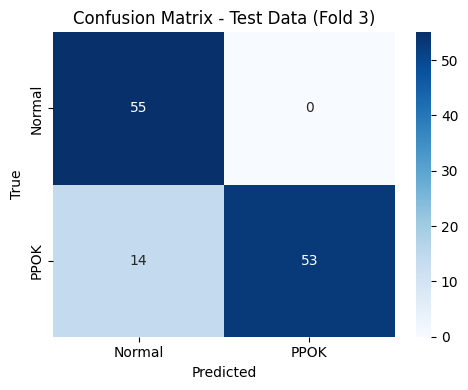

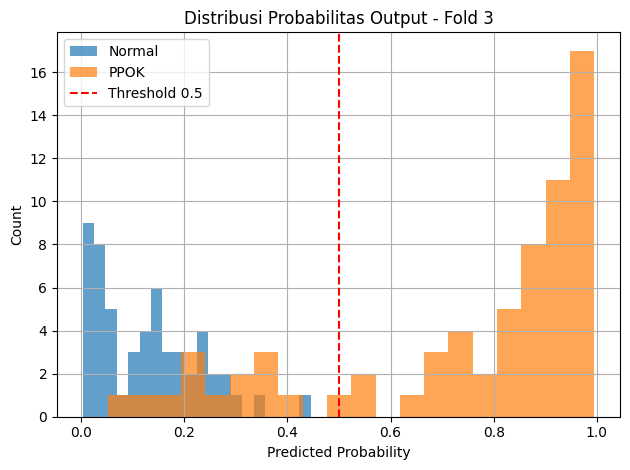


=== Evaluasi Model Fold 4 ===
✅ Test Metrics Fold 4:
  Loss: 0.5482 | Acc: 0.7131 | AUROC: 0.8289 | AUPRC: 0.8598
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step

📄 Classification Report:
              precision    recall  f1-score   support

      Normal       0.64      0.82      0.72        55
        PPOK       0.81      0.63      0.71        67

    accuracy                           0.71       122
   macro avg       0.73      0.72      0.71       122
weighted avg       0.73      0.71      0.71       122



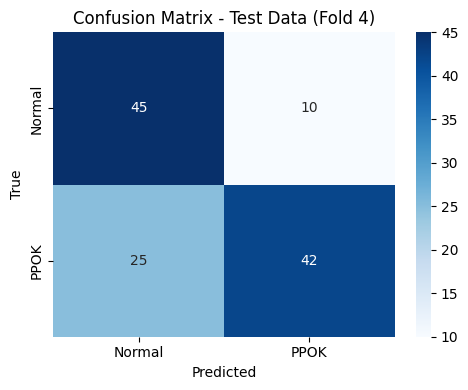

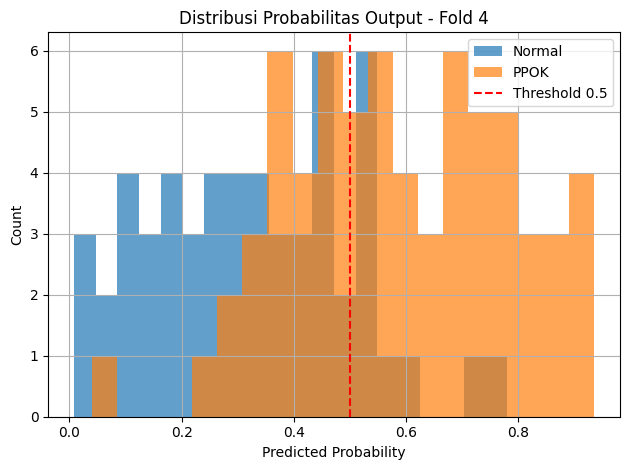


=== Evaluasi Model Fold 5 ===
✅ Test Metrics Fold 5:
  Loss: 0.4407 | Acc: 0.7869 | AUROC: 0.8986 | AUPRC: 0.9282
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step

📄 Classification Report:
              precision    recall  f1-score   support

      Normal       0.72      0.85      0.78        55
        PPOK       0.86      0.73      0.79        67

    accuracy                           0.79       122
   macro avg       0.79      0.79      0.79       122
weighted avg       0.80      0.79      0.79       122



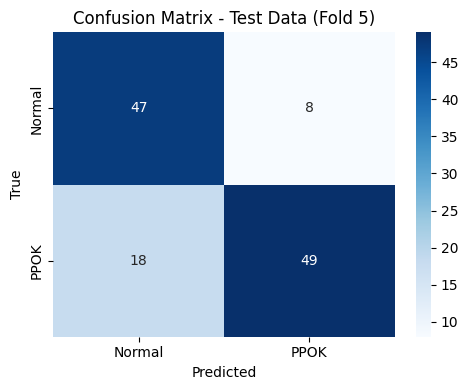

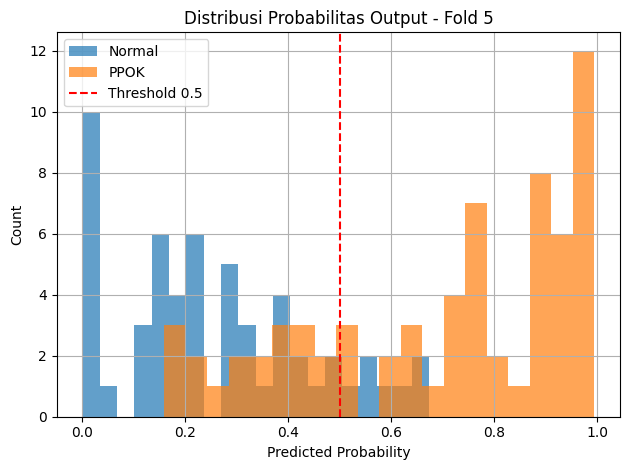


📊 Ringkasan Test Accuracy per Fold:
Fold 1: 0.8934
Fold 2: 0.8361
Fold 3: 0.8852
Fold 4: 0.7131
Fold 5: 0.7869

🔝 Rata-rata Akurasi Test: 0.8230


In [69]:
base_path = "J:/My Drive/01. TUGAS AKHIR/FOLDER TA/SOFTWARE/STA/Training_model/Model Checkpoint3"
test_accuracies = []

for fold_no in range(1, 6):
    print(f"\n=== Evaluasi Model Fold {fold_no} ===")

    model_path = f"{base_path}/Model_Fold{fold_no}.keras"
    model = tf.keras.models.load_model(model_path)

    # Evaluasi
    eval_results = model.evaluate(X_test_padded.astype('float32'), y_test_encoded, batch_size=16, verbose=0)
    loss = eval_results[0]
    acc = eval_results[1]
    auroc = eval_results[2]
    auprc = eval_results[3]

    test_accuracies.append(acc)

    print(f"✅ Test Metrics Fold {fold_no}:\n  Loss: {loss:.4f} | Acc: {acc:.4f} | AUROC: {auroc:.4f} | AUPRC: {auprc:.4f}")

    # Prediksi
    y_prob = model.predict(X_test_padded.astype('float32'), batch_size=16)
    y_pred = (y_prob > 0.5).astype(int).reshape(-1)

    # Classification Report
    print("\n📄 Classification Report:")
    print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Test Data (Fold {fold_no})')
    plt.tight_layout()
    plt.show()

    # Distribusi probabilitas output
    plt.hist(y_prob[y_test_encoded == 0], bins=20, alpha=0.7, label='Normal')
    plt.hist(y_prob[y_test_encoded == 1], bins=20, alpha=0.7, label='PPOK')
    plt.axvline(0.5, color='red', linestyle='--', label='Threshold 0.5')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.title(f'Distribusi Probabilitas Output - Fold {fold_no}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Bersihkan memori
    tf.keras.backend.clear_session()
    gc.collect()

# Ringkasan akhir
print("\n📊 Ringkasan Test Accuracy per Fold:")
for i, acc in enumerate(test_accuracies, 1):
    print(f"Fold {i}: {acc:.4f}")

print(f"\n🔝 Rata-rata Akurasi Test: {np.mean(test_accuracies):.4f}")

## **Prediction**

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.io import wavfile
import dwt_mfcc
from dwt_mfcc import process_signal_to_mfcc
import importlib
importlib.reload(dwt_mfcc)
import os
import warnings
warnings.filterwarnings("ignore")

In [3]:
def predict_all_folds_from_mfcc(mfcc_array, model_dir, n_folds=5, threshold=0.61):
    hasil_prediksi = []

    for fold_no in range(1, n_folds + 1):
        model_path = os.path.join(model_dir, f"Model_Fold{fold_no}.keras")
        model = tf.keras.models.load_model(model_path, compile=False)

        # Menyesuaikan dimensi input sesuai arsitektur model
        time_steps, n_features = model.input_shape[1], model.input_shape[2]
        total_required = time_steps * n_features

        fitur_flat = mfcc_array.flatten()
        if len(fitur_flat) < total_required:
            fitur_flat = np.pad(fitur_flat, (0, total_required - len(fitur_flat)), mode='constant')
        else:
            fitur_flat = fitur_flat[:total_required]

        X_input = fitur_flat.reshape(1, time_steps, n_features).astype('float32')
        pred_prob = model.predict(X_input, verbose=0)[0][0]
        pred_label = "Normal" if pred_prob < threshold else "PPOK"

        hasil_prediksi.append((fold_no, pred_prob, pred_label))
        tf.keras.backend.clear_session()

    return hasil_prediksi

In [180]:
# Folder input dan folder model
data_folder = "J:/My Drive/01. TUGAS AKHIR/FOLDER TA/SOFTWARE/Data_primer/MFCC_npy"
model_folder = "J:/My Drive/01. TUGAS AKHIR/FOLDER TA/SOFTWARE/STA/Training_model/Model Checkpoint3"
threshold = 0.7

hasil_semua = []

# Loop semua file .npy
file_list = [f for f in os.listdir(data_folder) if f.endswith(".npy")]
file_list.sort()

for i, filename in enumerate(file_list, start=1):
    file_path = os.path.join(data_folder, filename)

    try:
        mfcc_array = np.load(file_path)

        # Prediksi ke semua fold
        hasil_folds = predict_all_folds_from_mfcc(mfcc_array, model_folder, threshold=threshold)

        # Ambil probabilitas dan label
        probabilitas = [f"{prob:.4f}" for _, prob, _ in hasil_folds]
        label_folds = [label for _, _, label in hasil_folds]

        hasil_semua.append([i, filename] + probabilitas + label_folds)

    except Exception as e:
        print(f"❌ Error pada file {filename}: {e}")
        continue

# Simpan ke CSV
kolom = ["no", "filename"] + \
        [f"prob_fold_{i}" for i in range(1, 6)] + \
        [f"pred_fold_{i}" for i in range(1, 6)]

df_hasil = pd.DataFrame(hasil_semua, columns=kolom)
csv_path = "predict_dataprimer.csv"
df_hasil.to_csv(csv_path, index=False)

print(f"\n✅ Semua prediksi selesai! Hasil disimpan di: {csv_path}")


✅ Semua prediksi selesai! Hasil disimpan di: predict_dataprimer.csv


In [181]:
import pandas as pd

# ======= PATH FILE CSV =======
csv_path = "J:/My Drive/01. TUGAS AKHIR/FOLDER TA/SOFTWARE/STA/Training_model/predict_dataprimer.csv"
# ==========================================

# Baca CSV
df = pd.read_csv(csv_path)
print("\n📄 Dataframe hasil prediksi:")
df


📄 Dataframe hasil prediksi:


,no,filename,prob_fold_1,prob_fold_2,prob_fold_3,prob_fold_4,prob_fold_5,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,1,ana1.npy,0.3077,0.1668,0.1600,0.4215,0.1826,Normal,Normal,Normal,Normal,Normal
1,2,ana2.npy,0.1691,0.2205,0.1223,0.0814,0.0356,Normal,Normal,Normal,Normal,Normal
2,3,ana3.npy,0.0515,0.1185,0.0335,0.4455,0.1608,Normal,Normal,Normal,Normal,Normal
3,4,ana4.npy,0.2157,0.0878,0.1528,0.5387,0.4467,Normal,Normal,Normal,Normal,Normal
4,5,aris1.npy,0.1825,0.0213,0.0522,0.2237,0.0048,Normal,Normal,Normal,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
77,78,ratna4.npy,0.3422,0.2020,0.1078,0.5197,0.6437,Normal,Normal,Normal,Normal,Normal
78,79,sita1.npy,0.4250,0.3003,0.3887,0.3630,0.3752,Normal,Normal,Normal,Normal,Normal
79,80,sita2.npy,0.0132,0.0596,0.0119,0.4043,0.1546,Normal,Normal,Normal,Normal,Normal
80,81,sita3.npy,0.0160,0.0263,0.0058,0.4071,0.0304,Normal,Normal,Normal,Normal,Normal


In [182]:
print("\n📊 Rekap prediksi per Fold:")
for i in range(1, 6):
    col = f'pred_fold_{i}'
    counts = df[col].value_counts()
    normal_count = counts.get('Normal', 0)
    ppok_count = counts.get('PPOK', 0)
    print(f"📊 Fold {i} → Normal: {normal_count}, PPOK: {ppok_count}")


📊 Rekap prediksi per Fold:
📊 Fold 1 → Normal: 82, PPOK: 0
📊 Fold 2 → Normal: 81, PPOK: 1
📊 Fold 3 → Normal: 82, PPOK: 0
📊 Fold 4 → Normal: 78, PPOK: 4
📊 Fold 5 → Normal: 80, PPOK: 2


In [4]:
data_folder = "J:/My Drive/01. TUGAS AKHIR/FOLDER TA/SOFTWARE/Data_primer/MFCC_npy"
model_folder = "J:/My Drive/01. TUGAS AKHIR/FOLDER TA/SOFTWARE/STA/Training_model/Model Checkpoint3"
threshold = 0.7

# Inisialisasi jumlah TP dan FN per fold
TP_fold = [0] * 5
FN_fold = [0] * 5

# Loop semua file .npy
file_list = [f for f in os.listdir(data_folder) if f.endswith(".npy")]
file_list.sort()

for i, filename in enumerate(file_list, start=1):
    file_path = os.path.join(data_folder, filename)

    try:
        mfcc_array = np.load(file_path)

        # Prediksi ke semua fold
        hasil_folds = predict_all_folds_from_mfcc(mfcc_array, model_folder, threshold=threshold)

        for fold_no, prob, pred_label in hasil_folds:
            if pred_label == "Normal":
                TP_fold[fold_no - 1] += 1
            else:
                FN_fold[fold_no - 1] += 1

    except Exception as e:
        print(f"❌ Error pada file {filename}: {e}")
        continue

# Tampilkan hasil akhir
print("\n🔍 Hasil evaluasi data primer (semua = Normal):")
for i in range(5):
    print(f"Fold {i+1}: TP = {TP_fold[i]}, FN = {FN_fold[i]}")



🔍 Hasil evaluasi data primer (semua = Normal):
Fold 1: TP = 82, FN = 0
Fold 2: TP = 81, FN = 1
Fold 3: TP = 82, FN = 0
Fold 4: TP = 78, FN = 4
Fold 5: TP = 80, FN = 2


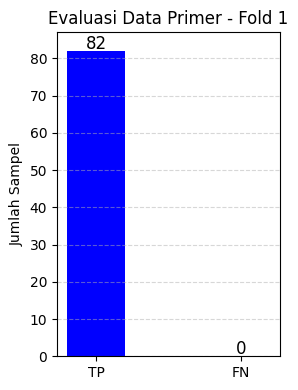

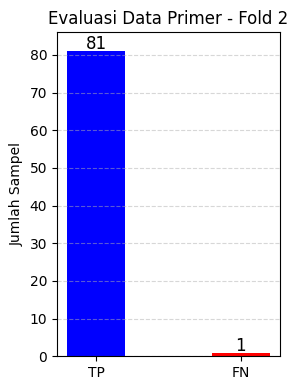

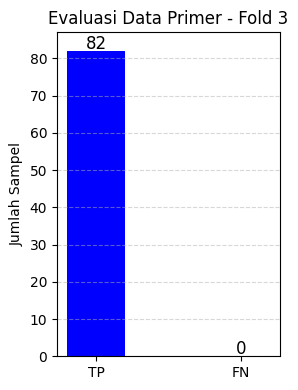

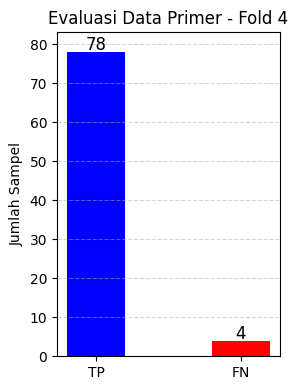

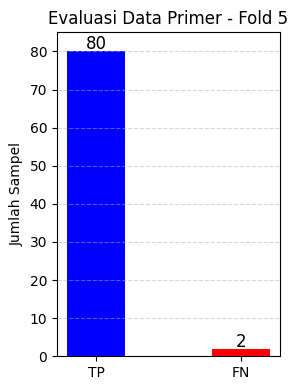

In [20]:
folds = [f"Fold {i+1}" for i in range(5)]
TP = TP_fold
FN = FN_fold

for i in range(5):
    fig, ax = plt.subplots(figsize=(3, 4))

    # Posisi X numerik agar bisa atur width
    x = np.array([0, 1])
    values = [TP[i], FN[i]]
    labels = ['TP', 'FN']
    colors = ['blue', 'red']

    # Bar plot dengan lebar kecil
    ax.bar(x, values, width=0.4, color=colors)

    # Anotasi nilai
    for xi, yi in zip(x, values):
        ax.text(xi, yi + 0.5, str(yi), ha='center', fontsize=12)

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, max(values) + 5)
    ax.set_title(f"Evaluasi Data Primer - {folds[i]}")
    ax.set_ylabel("Jumlah Sampel")
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

,Fold,TP,FN
0,Fold 1,82,0
1,Fold 2,81,1
2,Fold 3,82,0
3,Fold 4,78,4
4,Fold 5,80,2


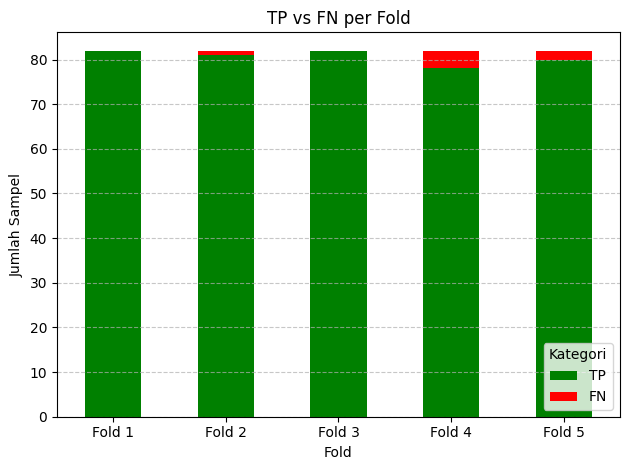

In [21]:
# Buat dataframe dari hasil evaluasi
df_eval = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(5)],
    "TP": TP_fold,
    "FN": FN_fold
})

# Tampilkan tabel dengan warna
from IPython.display import display
styled_table = df_eval.style.set_caption("Hasil Evaluasi per Fold (Data Primer = Normal)").background_gradient(cmap="Blues")
display(styled_table)

# Plot
df_eval.plot(kind='bar', x='Fold', stacked=True, color=["green", "red"])
plt.title("TP vs FN per Fold")
plt.ylabel("Jumlah Sampel")
plt.xlabel("Fold")
plt.xticks(rotation=0)
plt.legend(title="Kategori", loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()